<a href="https://colab.research.google.com/github/clovisdanielss/ProjetoCompletoDesenvolvedorIOMVCCore/blob/master/Anota%C3%A7%C3%B5es_Dominando_o_ASP_NET_MVC_Core_Projetos_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projeto Básico

### Modelos

- Enitity: Abstrata. 
  Implementa Id (Guid)
  Id iniciado no construtor
  Toda entidade do banco deve herdar dela

- Address
  - SupplierId: Guid, Supplier: Supplier, Street: string, Number: string, ZipCode: string, Neighboor: string, City: string, State: string

- Product
  - SupplierId: Guid, Supplier: Supplier, Name: string, Image:string, Value: decimal, CreatedDate: DateTime, Active: bool, Description: string

- Supplier
  - Name: string, Document: string, Type: SupplierType, Address: Address, Active: bool, Products: IEnumerable<Product>

- SupplierType:
  PF, PJ


### Única Camada

Usaremos um único contexto do Identity. Como essa aplicação é a básica, haverá somente uma camada.

Adicionar todas as entidades como DbSet no Contexto da applicação. 

### Atualizar Banco

Rodar um update-database. 

### Definir decorators com data annotations. 

Definir data anottations para:

```
[Required(ErrorMessage="")]
Name, Description, Image, Value, Street, Number, ZipCode, Neighboor, City, State, Document

[StringLenght(maxLen, ErrorMessage="", minLen)]
Name, Description, Image, Street, Number, ZipCode, Neighboor, City, State, Document

[DisplayName()]
Todos
```

### Atualizar banco
Gerar migration e update-database

### Gerar primeira tela
Controller => AddController => ControllerWithViews

Preencher formulário segundo o controlador que você quer criar. 

*Atenção se você realmente quer manter os binds*

*Atentar também para remover detalhes no front (Como a tela de Privacy)*

### Ajustes da tela de fornecedores
Usar scafold para criar essa view parcial de Endereço. 
Fazer uso apenas dos campos.
Remover Ids. 

Aplicar a view parcial ao Fornecedor

Remover Select, adicionar radio buttons


## Segunda Parte do Projeto Básico

### Adicionar demais controllers

Usar o scafold para adicionar os controllers dos Produtos. 

Melhorar tela de listagem removendo descrição

## Avançando no projeto - MVC Completa

Criar projeto em branco com somente solução. 
A raíz terá a estrutura:
- src
  - DevIO.App (Web MVC Com Identity)
    - [Será apresentado depois]
  - DevIO.Business (Class Library [.NETCore])
    - Models
    - Services
    - Validations
    - Interfaces
    - Notifications
  - DevIO.Data (Class Library [Idem])
    - Context
    - Mappings
    - Repositories
- tests
- sql

Ele também fala, que caso você possua multiplas versões de SDK, usar na raíz um global.json, com isso você irá definir qual SDK será usado na solução.

```json
{
  "projects":["src","tests"],
  "sdk":{
    "version":"7.0.0",
  }
}
```

Migrar as classes, sem anotations, para o projeto na pasta models.

## Configurando o EF

Criar Contexto de aplicação.
> instalar Microsoft.EntityFrameworkCore
> instaler Microsoft.EntityFrameworkCore.Relational


Ajustar o construtor para receber `DbContextOptions`
Definir os DBSet com os models da camada Dev.Business

> Usar FluentAPI para mapear entidades para banco de dados

Cada classe mapping precisa herdar de `IEntityTypeConfiguration<Model>`
Realizar o mapeamento de cada model. 

*Atenção, as configurações abaixo são redundantes porque o EF já é capaz de deduzir a configuração que colocamos pelos models. Todavia essa redundancia é importante para garantir que o EF não entenda nada errado.*

Usar a partir do builder `HasKey(), Property().IsRequired().HasColumnType("varchar(length)"), ToTable("TableName"), HasOne().WithOne(), HasMany().WithOne()`

> OBS: A classe que contém as filhas que configura o mapeamento

É preciso dar override no `OnModelCreating` do contexto. Usar `ApplyConfigurationFromAssembly(typeof(DbContext).Assembly)`, isso vai fazer com que ele receba todas as configurações criadas com o `IEntityTypeConfiguration<Model>`.

Adicionar o novo contexto no Program.cs da applicação. O contexto da aplicação é o que possui o usuário. O contexto aqui descrito é o que trata das entidades do negócio.

Devem ser criadas migrations para ambos contextos.
> Para usar script migration instalar o pacote Microsoft.EntityFrameworkCore.SqlServer, com isso é possível usar Script-Migration. Com isso ao invés de inserir no banco, é criado o sql para o banco. 

Essa figura demonstra outras configurações usadas; Mas uma é para garantir que não seja criada nvarchar no banco. A segunda é apenas para que não se use deleção em cascata. São configurações opicionais, que acho que não são necessárias. A configuração de deleção que ele usa é DeleteBehavior.ClientSetNull


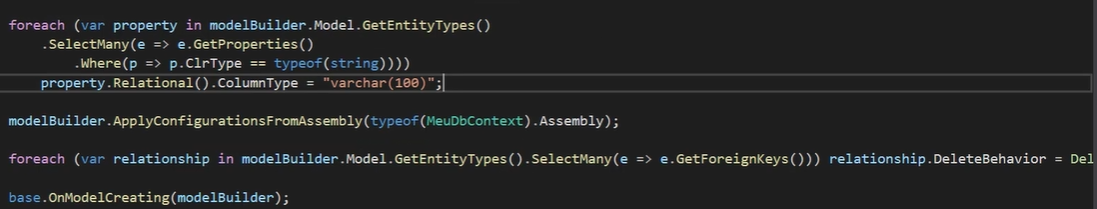

## Repositorio

Codar uma IRepository<T>. Esse repositório deverá estar na camada de negócios. A camada de negócio não conhece a camada de acesso a dados, somente o contrário. Assim, a única forma da camada de negócio ter acesso aos dados será pela interface. 

```C#
public interface IRepository<T> : Disposable where T: Entity{
  Task Add(T entity);
  Task<T> GetById(Guid Id);
  Task<IEnumerable<T>> GetAll();
  Task Update(T entity);
  Task Remove(Guid id);
  Task<IQueryable<T>> Query();
  Task<IQueryable<T>> QueryReadOnly();
  Task<int> SaveChanges();
}

```

Foi recomendado também que fossem criadas interfaces especializadas para cada entidade. 

```C#
public interface ISupplierRepository : IRepository<Supplier>{
  /// Deve incluir os produtos. 
  Task<IEnumerable<Supplier>> GetByIdWithProducts();
}
```

Implemetar o repositório como abstrato.

```C#
public abstract class Repository<T> : IRepository<T> where T : Entity{
  protected readonly DataContext context;
  protected readonly DbSet<T> entitySet;
  
  protected Repository(DataContext context){
    this.context = context;
    entitySet = context.DbSet<T>();
  }

  /// Dica de boa prática. Usar AsNoTracking para melhor performance quando readonly
  public async Task<IQueryable> QueryReadOnly(){
    return entitySet.AsNoTracking().AsQueryable();
  }
  public async Task<IQueryable> Query(){
    return entitySet.AsQueryable();
  }
  ...

  public void Dispose(){
    context?.Dispose();
  }
}
```

Em seguida ele recomenda implementar cada repositório para cada entidade. Normalmente eu só adiciono diretamente na injeção de dependência, mas acredito que como o Repository dele é abstrato não daria certo. 

Lembrando que como foi criado uma interface para cada repositório especifico, o objeto concreto deve implementar a interface do repositório referente a entidade. 

## Camada de aplicação

Na camada de aplicação, criar ViewModels para distiguir os modelos de exibição usados para a tela dos modelos de negócio. 

As ViewModels vão conter os data annotations que foram usados na parte básica do projeto [Basicamente vai ser só copiar e colar do projeto anterior].

> O campo CreatedDate deverá possuir a anotação `[ScaffoldColumn(false)]` para que o scaffold não trate como um campo da view. 

Adicionar outro campo parar imagem, um extra. `IFormFile` que receberá o arquivo upado. 

*Lembre-se de colocar o Id em cada ViewModel, pois eles não herdam de Entity*

> Instalar automapper, automapper.extensions.microsoft.dependencyinjection

`builder.Services.AddAutoMapper()`

Criar automapperconfig

```C#
public class AutoMapperConfig: Profile{
  public AutoMapperConfig(){
    CreateMap<Supplier, SupplierViewModel>().ReverseMap();
    ...
  }
}

```





## Scaffold das controllers 

Criar, através do Scaffold do VS, as controllers a serem usadas. 

Ajustar o `IFormFile`, ignorar o campo e fazer o scaffold sem ele.

- Remover _context da controller. 
- Retirar o dbset do AppContext. 
- Injetar repository via construtor. 
- Injetar mapper no construtor. Refatorar a controller. 
- Remover binds
- Ajustar front

> Criar BaseController, para futuras validações. 

Configurar o ProductViewModel para receber tambémm a lista de fornecedores. 




## Refatorando views

- Criar partial view para endereço. 
- Fazer uso somente dos campos de formulário, como antes fizemos. 
- Usar o cep como primeiro campo. 

`<partial-view name="_Address"/>`

- Não esquecer de traduzir os textos. 
- Mudar links para "btn btn-info".

- Transformar links da tabela de listagem em botões. 
- Alinhar esses botões a direita. 
- Usar na table class "table table-hover", e no thead "thead-dark"
- Add -> ClientSideLibrary -> font-awesome
- Substituir nomes por ícones. `<spam class="fa fa-search">, <spam class="fa fa-pencil-alt"> <span class="fa fa-trash">`
- Refatorar a tela de produtos, para não usar ViewBag, mas sim diretamente o AllSupliers, lembrando que isso significa repassar a SelectedList da linha de código para o cshtml (Opicional, honestamente achei mais bonito mandando a bag). 
- Verificar se o campo do SupplierId tá com validação. 
- Alterar Image para ImageUpload. 
```html
<label asp-for="ImageUpload" class="control-label"></label>
<div class="custom-file">
     <input type="file" class="custom-file-input" id="ImageUpload" asp-for="ImageUpload"/>
     <label data-browse="Procurar" style="width:400px" class="custom-file-label" for="ImageUpload"></label>
     <label style="display:none" id="img_name"></label>
</div>
```
```
@section Scripts{
  @{await Html.RenderPartialAsync("_ValidationScriptsPartial")}
  <script>
    $("#ImageUpload").change(()=>{
      $("#img_name").text(this.files[0].name);
      $("#img_name")[0].style.display = 'block';
    })
    $("#ImageUpload").attr("data-val", "true");
    $("#ImageUpload").attr("data-val-required", "Preencha o campo Imagem");
  </script>
}
```
- adicionar `enctype="multipart/form-data"` ao formulário, já que vamos subir um arquivo.
- adicionar no produto (listagem) um th para imagem (vazio). Nesse caso seria o primeiro campo. Também remover o campo "Imagem" e "Descrição".
- Fazer as mesmas alterações de tabela já descritas. 



## Fazendo upload

Fazendo upload de forma estatica no servidor. Claro que em uma applicação real, não é legal fazer isso.

```C#
...
var imgPrefix = Guid.NewGuid() + "_" ;
if(!await UploadImage(productViewModel.ImageUpload, imgPrefix)){
  return View(productViewModel);
}
productViewModel.Image = imgPrefixo + productViewModel.ImageUpload.FileName;
...

public async Task<bool> UploadImage(IFormFile imageUpload, imgPrefix){
  if(imageUpload.Length <= 0) return false;
  var path = Path.Combine(Directory.GetCurrentDirectory(), "wwwroot/images", imgPrefix + imageUpload.FileName);
  if(System.IO.File.Exists(path)){
    ModelState.AddModelError(string.Empty, "Já existe arquivo com esse nome");
    return false;
  }
  using(var stream = new FileStream(path, FileMode.Create))
  {
    await imageUpload.CopyToAsync(stream);
  }
  return true;
}
```

Na index de exibição de produto:
```
<td>
    <img src="~/imagens/@item.Image" alt="@item.Image" style="width: 70px; height: 100px;"/>
</td>
```

## Mudança nas telas de produtos

- Colocar text-area para input da Description 
- Para imagem:
- Não esquecer de mudar o encrypt do form
```html
<div>
    <label>Imagem Atual</label>
    <br/>
    <img src="~/images/@Model.Image" alt="@Model.Image" style="width:70px; height:100px;" />
</div>
<div class="form-group">
    <label asp-for="ImageUpload" class="control-label"></label>
    <div class="csutom-file">
        <label data-browse="Procurar" style="width:400px" class="custom-file-label" for="ImageUpload"></label>
        <label style="display: none" id="img_name"></label>
    </div>
</div>
```

Sobre o botão de voltar:
```html
<a class="btn btn-info" href="javascript:window.history.back();"> Voltar </a>
```

E não esquecer do javascript:
```javascript
 $("#ImageUpload").change(()=>{
    $("#img_name").text(this.files[0].name);
    $("#img_name")[0].style.display = 'block';
  })
```

No edit, na hora de puxar a tela no controlador, alimentar com o fornecedor e imagem que estão no banco. Validar se a imagem foi preenchida. Repetir o código 

```
var imgPrefix = Guid.NewGuid() + "_" ;
if(!await UploadImage(productViewModel.ImageUpload, imgPrefix)){
  return View(productViewModel);
}
productViewModel.Image = imgPrefixo + productViewModel.ImageUpload.FileName;
```

Usar a instancia do banco para atualizar os valores que vem da view model:
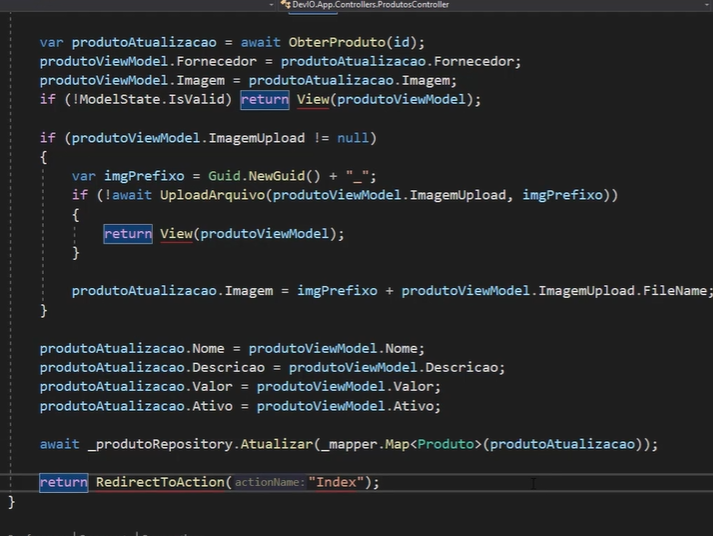 

## Globalização

No startup adicionar `app.UseRequestLocalization`
```C#
var defaultCulture = new CultureInfo("pt-BR");
var localizationOptions = new RequestLocalizationOptions
{
  DefaultRequestCulture = new RequestCulture(defaultCulture),
  SupportedCultures = new List<CultureInfo> {defaultCulture},
  SupportedUICultures = new List<CultureInfo> {defaultCulture},
};
app.UseRequestLocalization(localizationOptions);
```

Nesse caso, seria necessário sobrescrever a validação do jquery (_ValidationScriptPartial):
```html
<script>
  $.validator.methods.range = function(value, element, param){
    var globalizationValue = value.replace(",",".");
    return this.opitional(element) || (globalizationValue >= param[0] && globalizationValue <= param[1]);
  };

  $.validator.methods.number = function(value, element){
    return this.opitional(element) || /(?:\d{1,3})((?:[\s\.,]\d{3})+(?:[\.,]\d+)?)?$/.test(value);
  };

  $.validator.methods.date = function(value, element){
    var date = value.split("/");
    return this.optional(element) || !/Invalid|NaN/.test(new Date(date[2], date[1], date[0]).toString());
  };
</script>
```

Precisamos também traduzir as mensagens de validação. No startup, precisamos configurar o mvc.

```C#
AddMvc(o => {
  o.ModelBindingMessageProvider.SetAttemptedValueIsInvalidAccessor((x,y) => "O valor preenchido é inválido para este campo");
  o.ModelBindingMessageProvider.SetMissingBindRequiredValueAccessor((x) => "Este campo precisa ser preenchido");
  o.ModelBindingMessageProvider.SetMissingKeyOrValueAccessor(() => "Este campo precisa ser preenchido");
  o.ModelBindingMessageProvider.SetMissingRequestBodyRequiredValueAccessor(() => "É necessário que o body na requisição não esteja vazio");
  o.ModelBindingMessageProvider.SetNonPropertyAttemptedValueIsInvalidAccessor((x) => "O valor preenchido é inválido para este campo");
  o.ModelBindingMessageProvider.SetNonPropertyUnkownValueIsInvalidAccessor(() => "Este campo precisa ser preenchido");
  o.ModelBindingMessageProvider.SetNonPropertyValueMustBeANumberAccessor(() => "O campo deve ser numérico");
  o.ModelBindingMessageProvider.SetUnknownValueIsInvalidAccessor((x) => "O valor preenchido é inválido para este campo");
  o.ModelBindingMessageProvider.SetValueIsInvalidAccessor((x) => "O valor preenchido é inválido para este campo");
  o.ModelBindingMessageProvider.SetValueMustBeANumberAccessor((x) => "O campo deve ser numérico");
  o.ModelBindingMessageProvider.SetValueMustNotBeNullAccessor((x) => "Este campo precisa ser preenchido");
})
```

Criar extensão (pasta extensions)
Criar um CurrencyAttribute
```C#
public class CurrencyAttribute: ValidationAttribute{
  protected override ValidationResult IsValid(object value, ValidationContext validationContext){
    try{
      var currency = Convert.ToDecimal(value, new CultureInfo("pt-BR"));
    }catch(Exception){
      return new ValidationResult("Moeda em formato inválido");
    }
    retrun ValidationResult.Success;
  }
}
```

Decorar o value do product com Currency. As classes abaixo são para funcionamento da validação do lado do cliente.

```Csharp
public class CurrencyAttributeAdapter: AttributeAdapterBase<CurrencyAttribute>{
  //usar ctor

  public override void AddValidation(ClientModelValidationContext context){
    if(context == null) throw new ArgumentNullException();

    MergeAttribute(context.Attributes, "data-val", "true");
    MergeAttribute(context.Attributes, "data-val-currency", GetErrorMessage(context));
    MergeAttribute(context.Attributes, "data-val-number", GetErrorMessage(context))

  }

  public override string GetErrorMessage(ModelValidationContextBase context){
    return "Moeda em formato inválido";
  }
}

public class CurrencyValidationAttributeAdapterProvider : IValidationAttributeAdapterProvider{
  private readonly IValidationAttributeAdapterProvider _baseProvider = new ValidationAttributeAdapterProvider();

  public IAttributeAdapter GetAttributeAdapter(ValidationAttribute attribute, IStringLocalizer stringLocalizer){
    if(attribute is CurrencyAttribute currencyAttribute){
      return new CurrencyAttributeAdapter(currencyAttribute, stringLocalizer);
    }
    return _baseProvider.GetAttributeAdapter(attribute, stringLocalizer);
  }
}

//no service
AddSingleton<IValidationAttributeAdapterProvider, CurrencyValidationAttributeAdapterProvider>();
```


Na exibição do valor colocar ToString("C"); C é de currency, com isso vai ser formatado no valor da moeda. 

## Algumas refatorações

Colocar o textarea também na criação do produto.
Colocar imagem do produto nos detalhes. 
divida em duas colunas e coloque a imagem do lado. 
Use javascript: window.history.back() para voltar. 
Fazer o mesmo para deleção. 

Nos detalhes do desenvolvedor mostrar o endereço do mesmo (Fazer isso criando partial view). 
Criar uma extensão para o Razor;

```C#
public static class RazorExtensions{
    public static string FormatDocument(this RazorPage page, int typePerson, string document){
        return typePerson == 1 ?
          Convert.ToUIInt64(document).ToString(@"000\.000\.000\-00"):
          Convert.ToUIInt64(document).ToString(@"00\.000\.000\/0000\-00");
    }
}
```

Chamar o FormatDocument no Index do Supplier.

Ele deu uma refatorada nos formularios para dividir em duas colunas. 
Ele também modularizou a lista de produtos. Deixando somente a tabela, em uma partial. E então usou a tabela onde ele quis.

`<partial name="../Products/_Index" model="@Model.Products">` onde @Model é o Supplier.

Refatorar os botões para passar asp-controller dos produtos, para que então eles fiquem funcionais. 




## Criando modal

Adiciona as partials que criou no ultimo tópico também na edição de fornecedor

Adicionar partial vazia para atualizar endereço.


```html
<div class="modal-header">
  <h4 class="modal-title">Atualizar endereço</h4>
  <button type="button" class="close" data-dismiss="modal">
    <span aria-hidden="true">x</span><span class="sr-only">Fechar</span>
  </button>
</div>
<form asp-action="AtualizarEndereço">
  <div class="modal-body">
    <input type="hidden" asp-for="Address.SupplierId" />
    <input type="hidden" asp-for="Address.Id" />

    <partial name="_AddressPartial" />
    
    <div class="modal-footer">
      <div class="col-md-offset-2 col-md-10">
        <input type="submit" value="Atualizar Endereço" class="btn btn-success" />
        <input type="button" value="Fechar" class="btn btn-info" data-dismiss="modal"/>
    </div>
  </div>
</form>
```

Modificar botão de atualizar endereço do index para uma action atualizar endereço. Adicionar um data-modal no botão também. 

Criar o método que retorna a partialView. Exemplo:

```C#
public async Task<IactionResult> UpdateAddress(Guid ID){
  //pega fornecedor

  return PartialView("_ViewName", new SupplierViewModel { Address = supplier.Address});
}
```

Criar também o seguinte script usando ajax
```javascript
$(document).ready(()=>{
  AjaxModal();
})
```
Adicionar no sitejs. Detestei essa parte porque não gosto de sair copiando código, mas não tô afim de me preocupar em fazer uma modal funcionar. 

```
function SetModal() {

    $(document).ready(function () {
        $(function () {
            $.ajaxSetup({ cache: false });

            $("a[data-modal]").on("click",
                function (e) {
                    $('#myModalContent').load(this.href,
                        function () {
                            $('#myModal').modal({
                                    keyboard: true
                                },
                                'show');
                            bindForm(this);
                        });
                    return false;
                });
        });
    });
}

function bindForm(dialog) {
    $('form', dialog).submit(function () {
        $.ajax({
            url: this.action,
            type: this.method,
            data: $(this).serialize(),
            success: function (result) {
                if (result.success) {
                    $('#myModal').modal('hide');
                    $('#EnderecoTarget').load(result.url); // Carrega o resultado HTML para a div demarcada
                } else {
                    $('#myModalContent').html(result);
                    bindForm(dialog);
                }
            }
        });

        SetModal();
        return false;
    });
}

function BuscaCep() {
    $(document).ready(function () {

        function limpa_formulário_cep() {
            // Limpa valores do formulário de cep.
            $("#Endereco_Logradouro").val("");
            $("#Endereco_Bairro").val("");
            $("#Endereco_Cidade").val("");
            $("#Endereco_Estado").val("");
        }

        //Quando o campo cep perde o foco.
        $("#Endereco_Cep").blur(function () {

            //Nova variável "cep" somente com dígitos.
            var cep = $(this).val().replace(/\D/g, '');

            //Verifica se campo cep possui valor informado.
            if (cep != "") {

                //Expressão regular para validar o CEP.
                var validacep = /^[0-9]{8}$/;

                //Valida o formato do CEP.
                if (validacep.test(cep)) {

                    //Preenche os campos com "..." enquanto consulta webservice.
                    $("#Endereco_Logradouro").val("...");
                    $("#Endereco_Bairro").val("...");
                    $("#Endereco_Cidade").val("...");
                    $("#Endereco_Estado").val("...");

                    //Consulta o webservice viacep.com.br/
                    $.getJSON("https://viacep.com.br/ws/" + cep + "/json/?callback=?",
                        function (dados) {

                            if (!("erro" in dados)) {
                                //Atualiza os campos com os valores da consulta.
                                $("#Endereco_Logradouro").val(dados.logradouro);
                                $("#Endereco_Bairro").val(dados.bairro);
                                $("#Endereco_Cidade").val(dados.localidade);
                                $("#Endereco_Estado").val(dados.uf);
                            } //end if.
                            else {
                                //CEP pesquisado não foi encontrado.
                                limpa_formulário_cep();
                                alert("CEP não encontrado.");
                            }
                        });
                } //end if.
                else {
                    //cep é inválido.
                    limpa_formulário_cep();
                    alert("Formato de CEP inválido.");
                }
            } //end if.
            else {
                //cep sem valor, limpa formulário.
                limpa_formulário_cep();
            }
        });
    });
}

$(document).ready(function () {
	$("#msg_box").fadeOut(2500);
});
```

Adicionar modal no final da página (Ediçaõ de fornecedor). Passar asp-route-Id no botão de editar endereço. 
```html
<div id="MyModal" class="modal fade in">
  <div class="modal-dialog"> 
    <div class="modal-content">
      <div id="myModalContent"></div>
    </div>
  </div>
</div>
```

Criar na controller o método de atualizar endereço (POST).
O método deve ter o seguinte retorno:
```C#
ModelState.Remove("Nome");
ModelState.Remove("Documento");
if (!ModelState.IsValid) return PartialView("_AtualizarEndereco", fornecedorViewModel);
await _fornecedorService.AtualizarEndereco(_mapper.Map<Endereco>(fornecedorViewModel.Endereco));
if (!OperacaoValida()) return PartialView("_AtualizarEndereco", fornecedorViewModel);
var url = Url.Action("ObterEndereco", "Fornecedores", new { id = fornecedorViewModel.Endereco.FornecedorId });
return Json(new { success = true, url });
```
Criar método GetAddress, retornar partialview detalhes de endereço (Já implementada). 

Colocar a tag `id="EnderecoTarget"` no partial da modal.

## Cep autocomplete

Usar aquele script do ajax para pegar o CEP. 
> OBS: Os ids dos campos do model tem o formato NomeDoModel_NomeDoAtributo.

Fazer a chamada do método `BuscaCep`, basta chamar o método na parte de scripts da página desejada.

## Criar extensions para startup.

Opicional, mas colocando aqui no guia para eu lembrar que ele fez isso. 

Ele criou um tag-helper.
```C#
public class EmailTagHelper: TagHelper{
  public string EmailDomain {get;set;} = "@cdss.com"
  public override async Task ProcessAsync(TagHelperContext context, TagHelperOutput output){
    output.TagName = "a";
    var content = await output.GetChildContentAsync();
    var target = content.GetContent() + $"@{EmailDomain}";
    output.Attributes.SetAttribute("href", $"mailto: {target}");
    output.Content.SetContent(target)
  }
}
//colocar o @addTagHelper nas _ViewImports
```

Também ele colocou uma configuração para os appsettings no StartUp:
```C#

var builder = new ConfigurationBuilder()
                  .SetBasePath(hostEnvironment.ContentRootPath)
                  .AddJsonFile("appsettings.json", true, true)
                  .AddJsonFile($"appsettings.{hostname.EnvironmentName}.json", true, true)
                  .AddEnvironmentVariables()

if(hostEnvironment.IsDevelopment()){
  builder.AddUserSecrets<Startup>();
}

configurations = builder.Build();

```

## Roteamento Inteligente

Também opicional, ele modificou o nome das rotas usando o RouteAttribute. 

## Validação das entidades do lado da camada de negócio

- Criar 3 classes de serviços.
  - BaseService
  - SupplierService, ISupplierService
  - ProductService, IProductService
- Métodos Add, Remove, Update, UpdateAddress
> Dica, usar o FluentValidation do .netcore
- Criar validations para supplier e product. `SupplierValidator: AbstractValidator<Supplier>`

```
RuleFor(f => f.Name)
    .NotEmpty()
    .WithMessage("O campo {PropertyName} precisa ser fornecido")
    .Lenght(2,100)
    .WithMessage("O campo {PropertyName} precisa ter de {MinLenght} à {MaxLenght} caracteres");
When(f => f.Type == Type.PF, ()=>{
  RuleFor //...
})
//Fazer o mesmo para PJ
```

Ele pegou os métodos de validação de cpf e cnpj para validar o documento.

```C#
public abstract class BaseService{
  protected void Notify(ValidationResult val){
    foreach(var error in val.Errors){
      Notify(error);
    }
  }

  protected void Notify(string message){
    //Usar eventos para propagar erro
  }

  protected bool Validate<TValidation, TEntity>(TValidation validation, TEntity entity) where TValidation: AbstractValidator<TEntity> where TEntity : Entity {
    var validator = validation.Validate(entity);
    if(validator.IsValid) return true;
    Notify(validator);
    return false;
  }
} 
```
O método adicionar, assim como os demais, devem chamar o método Validate do BaseClass.

## Propagando mensagens com eventos

Fazer a injeção dos repositórios. 

Usar o repository para slavar itens validados. 

Ele colocou as validações de repositório (documentos iguais e ids diferentes) fora do validation

Também adicionou validação para remoção. Lembra que ele não usa cascade ? Aí justamente aí que ele alerta a validação. 

As interfaces dos serviços devem implementar o IDisposable

Criar interface `INotifier`
```C#
/// verifica a lista
bool HasNotification();
/// devolve a lista
List<Notification> GetNotifications();
/// insere na lista
void Handle(Notification notification);
```

Criar classe `Notification` e `Notifier`

Notification deve ter uma propriedade Mensagem.

Injetar em dependencia os serviços e a notificação. 

Adicionar o notificador no BaseService. Adicionar nova notificação dentro do notificador. 

Injetar serviço nos controladores. Os controladores vão ter acesso ao reposuitory apenas para pegar os resultados.

Injetar na baseController o notificador. Implementar:
```C#
protected bool ValidOperation(){
  return !notification.HasNotification;
}
```

Validar nas chamadas:
```
if(!ValidOperation())
  return view...
```

Criar um recurso. Uma extenção, ViewComponent para exibir as notificações. 

```
public clas SummaryViewComponent: ViewComponent{
  //injetar notification

  public async Task<IViewComponentResult> InvokeAsync(){
    var notifications = await Task.FromResult(_notificator.GetNotifications());
    notifications.ForEach(c => ViewData.ModelState.AddModelError(string.Empty, c.Message));
    return View();
  }
}
```

Criar Shared>Components>Summary>Default.cshtml;
```
//<div asp-validation-summary="All" class="text-danger"></div>
//<vc:Summary></vc:Summary>
// 
@if(ViewData.ModelState.ErrorCount > 0){
  <div style="padding-top: 15px;"></div>
  <div class="alert alert-danger">
      <button type="button" class="close" data-dismiss="alert">x</button>
      <h3>Algo deu errado :( </h3>
      <div style="padding-top: 20px" asp-validation-summary="ModelOnly" class="text-danger"></div>
  </div>
}

@if(!string.IsNullOrEmpty(ViewBag.Success)){
  <div style="padding-top: 15px;"></div>
  <div class="alert alert-success">
      <button type="button" class="close" data-dismiss="alert">x</button>
      <h3 id="returnMsg">@ViewBag.Success</h3>
  </div>
}

@if(TempData["Success"] != null){
  <div style="padding-top: 15px;"></div>
  <div class="alert alert-success">
      <button type="button" class="close" data-dismiss="alert">x</button>
      <h4 id="returnMsg">@Html.Raw(TempData["Success"].ToString())</h4>
  </div>
}
```

No delete confirmed, adicionar mensagem de sucesso ao TempData. 
Adicionar o seguinte javascript
```
$(document).ready(function(){
  $("#msg_box").fadeOut(2500);
})
```



## Mudanças e configurações no Identity

Criar CustomAuthorize 
```C#
public class CustomAuthorization{
  public static bool ValidateUserClaims(HttpContext context, string claimName, string claimValue){
    return context.User.Identity.IsAuthenticated &&
    context.User.Claims.Any(c => c.Type == claimName && c.Value.Contains(claimValue));
  }
}

public class ClaimsAuthorizeAttribute{
  public ClaimsAuthorizeAttribute(string claimName, string claimValue) : base(typeof(RequestClaimFilter)){
    Arguments = new object [] {new Claim(claimName, claimValue)};
  }
}

public class RequestClaimFilter: IAuthorizationFilter{
  private readonly Claim _claim;
  public RequestClaimFilter(Claim claim){
    _claim = claim;
  }
  public void OnAuthorization(AuthorizationFilterContext context){
    if(!context.HttpContext.User.Identity.IsAuthenticated){
      context.Result = new RedirectToRouteResult(new RouteValueDictionary(new {area = "Identity", page = "/Account/Login", ReturnUrl = context.HttpContext.Request.Path.ToString() }));
      return;
    }
    if(!CustomAuthorization.ValidateUserClaims(context.HttpContext, _claim.Type, _claim.Value)){
      context.Result = new StatusCodeResult(403);
    }
  }
}

```

Usar os decorators para as rotas como desejar. Não esqueça de adicionar as claims no banco. 

| Claim   | Valor |
|----------|:-------------:|
|Produto | Criar, Editar, Deletar|
|Fornecedor | Criar, Editar,  Deletar|

Criar uma classe para suprimir html através de atributos do dotnet.
`suppress-by-claim-name` e `suppress-by-claim-value`

```C#
[HtmlTargetElement("*", Attributes="suppress-by-claim-name")]
[HtmlTargetElement("*", Attributes="suppress-by-claim-value")]
public class SuppressElementByClaimTagHelper : TagHelper{
  private readonly IHttpCotnextAccessor _contextAccessor;

  public SuppressElementByClaimTagHelper(IHttpContextAccessor context){
      _contextAccessor = context;
  }

  [HtmlAttributeName("suppress-by-claim-name")]
  public string ClaimName {get;set;}
  [HtmlAttributeName("suppress-by-claim-value")]
  public string ClaimValue {get;set;}

  public override void Process(TagHelperContext context, TagHelperOutput output){
    if(context == null) throw new ArgumentNullException
    if(output == null) throw new ArgumentNullException
    hasAccess = CustomAuthorization.ValidateUserClaim(_contextAccessor.HttpContext, ClaimName, ClaimValue);

    if(hasAccess) return;

    output.SuppressOutput();
  }
}

[HtmlTargetElement("a", Attributes="disable-by-claim-name")]
[HtmlTargetElement("a", Attributes="disable-by-claim-value")]
public class DisableLinkByClaimTagHelper : TagHelper{
  private readonly IHttpCotnextAccessor _contextAccessor;

  public DisableLinkByClaimTagHelper(IHttpContextAccessor context){
      _contextAccessor = context;
  }

  [HtmlAttributeName("disable-by-claim-name")]
  public string ClaimName {get;set;}
  [HtmlAttributeName("disable-by-claim-value")]
  public string ClaimValue {get;set;}

  public override void Process(TagHelperContext context, TagHelperOutput output){
    if(context == null) throw new ArgumentNullException
    if(output == null) throw new ArgumentNullException
    hasAccess = CustomAuthorization.ValidateUserClaim(_contextAccessor.HttpContext, ClaimName, ClaimValue);

    if(hasAccess) return;

    output.Attributes.RemoveAll("href");
    output.Attributes.Add(new TagHelperAttribute("style", "cursor: not-allowed"));
    output.Attributes.Add(new TagHelperAttribute("title", "você não tem permissão"));
  }
}

// Esse a seguir serve para caso eu não esteja no contexto de uma determinada ação;
[HtmlTargetElement("a", Attributes="suppress-by-action")]
public class SuppressByActionTagHelper : TagHelper{
  private readonly IHttpCotnextAccessor _contextAccessor;

  public SuppressByActionTagHelper(IHttpContextAccessor context){
      _contextAccessor = context;
  }

  [HtmlAttributeName("suppress-by-action")]
  public string ActionName {get;set;}

  public override void Process(TagHelperContext context, TagHelperOutput output){
    if(context == null) throw new ArgumentNullException
    if(output == null) throw new ArgumentNullException
    
    var action = _contextAccessor.HttpContext.GetRouteData().Values["action"].ToString();

    if(ActionName.Contains(action)) return;

    output.SuppressOutput();
  }
}
```
apagar botões de deletar quando o usuário não tiver permissão e de editar. 

## Tratamento de erros 

No startup
```C#
//fora de desenvolvimento
app.UseExceptionHandler("/error/500")
app.UseStatusCodePagesWithRedirects("/error/{0}")
```

Crirar um errorViewModel com mensagem título e código; Criar no home um roteador para o erro. 

Alterar view de error. 

## Segurança

`app.UseHsts()` Strict-transport-security header. Força a usar uma conexão segura. Redireciona para https. 

`app.UseHttpsRedirection()` também redireciona, como o hsts. Mas o Hsts, faz primeiro uma negociação com o navegador.

Essa redundancia é necessária para garantir que a primeira chamada do browser seja realizada em https, garantindo que o hsts funcione nas demais requisições.

O hsts serve para proteger do man-in-the-middle.

O validate anti forgery token serve justamente para se tentar fazer uma chamada da aplicação através de uma página falsa, a requisição falhar. 

O exemplo dado é simples, criar uma página fake, preencher os dados e enviar a requisição para aplicação de forma que o usuário não perceba (através de um formulário já preenchido e um link falso). 

No addMvc é possível adicionar o seguinte: `option.Filtes.Add(new AutoValidateAntiForgeryTokenAttribute())`
